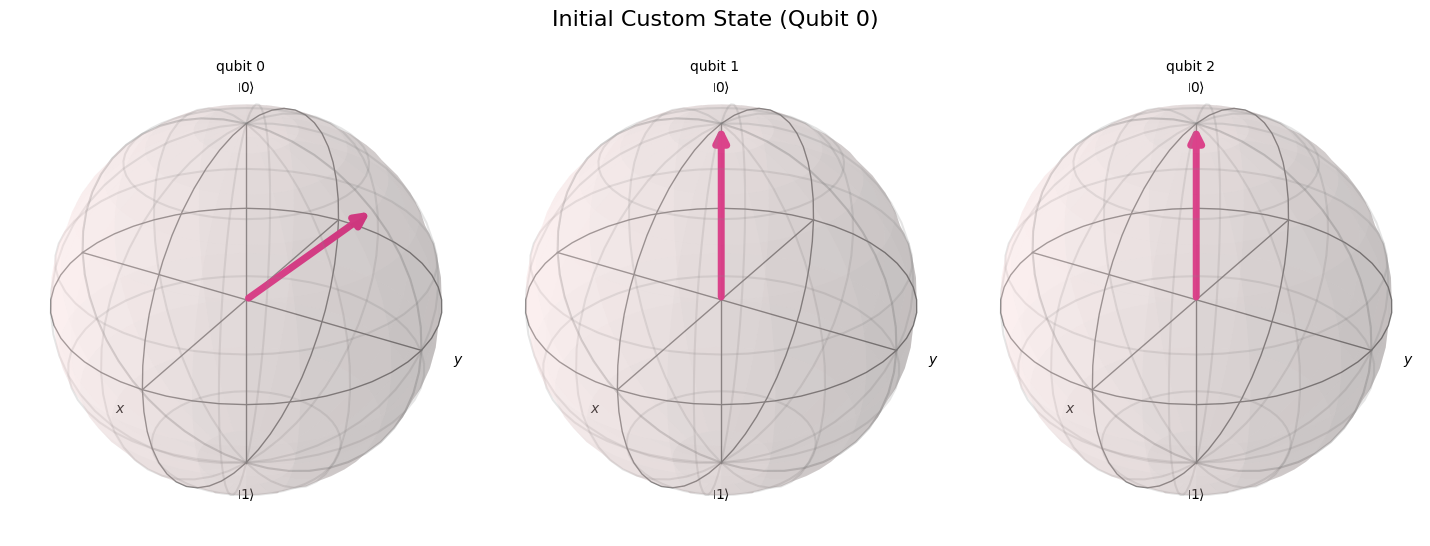

Task 1 — Fidelity = 1.000000


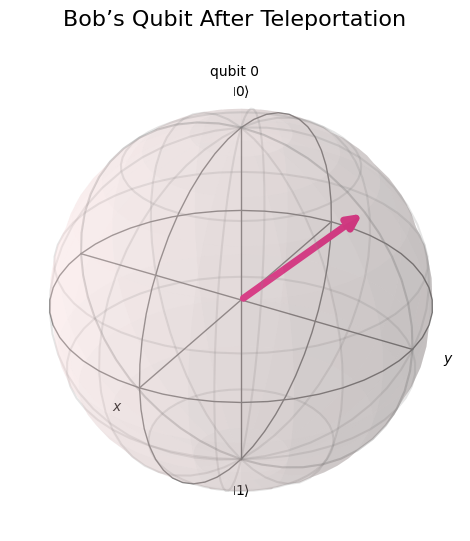


Task 2 — Bloch sphere of Bob’s final qubit after classical corrections:


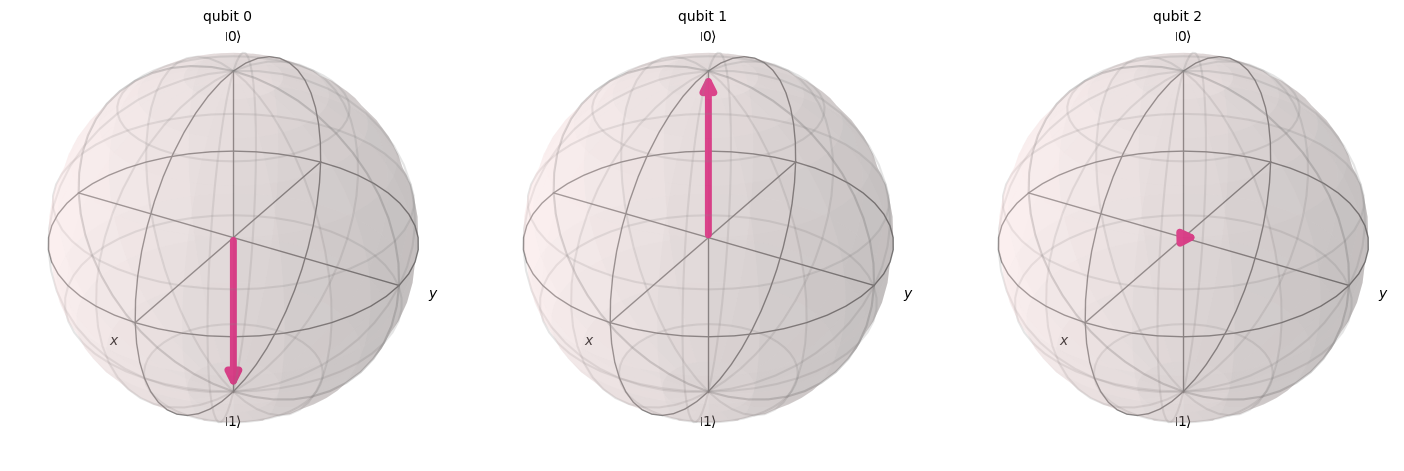

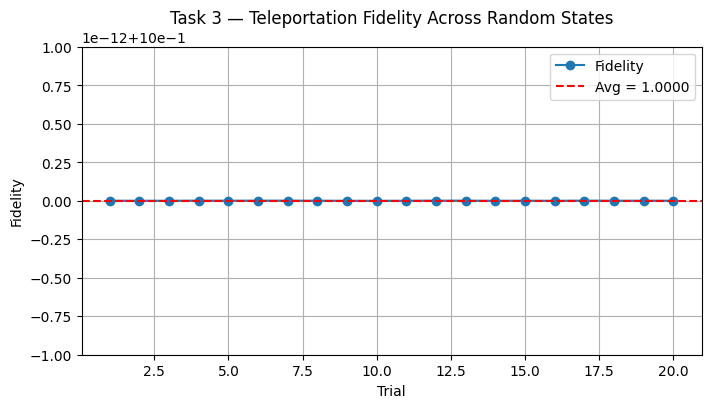

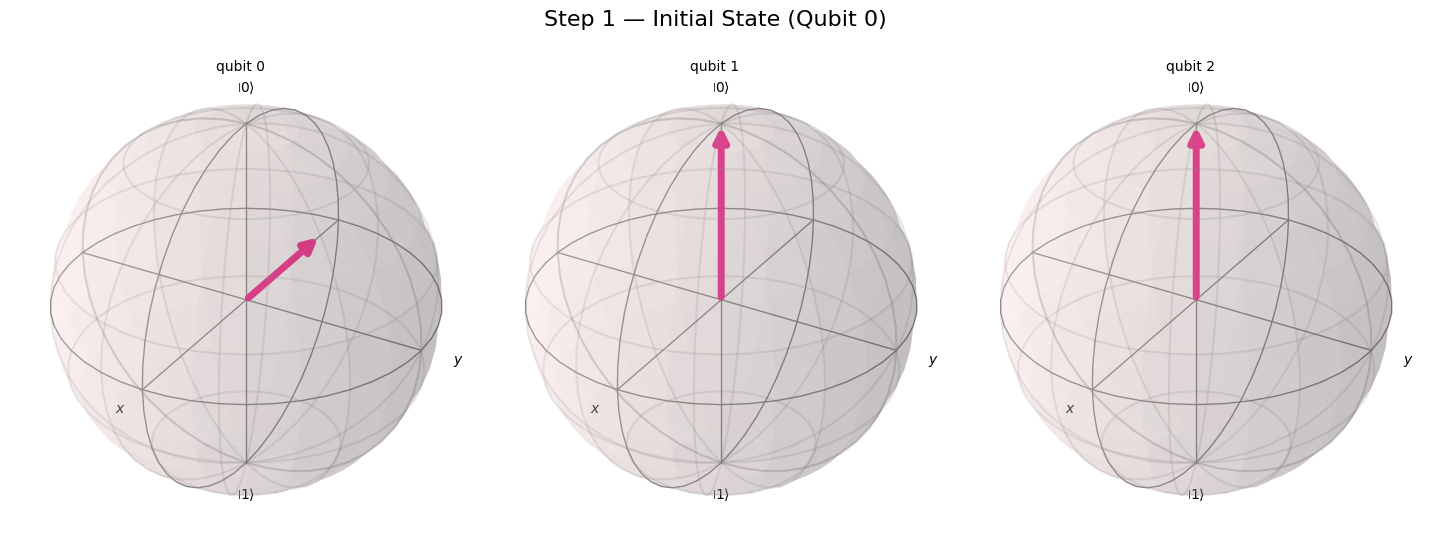

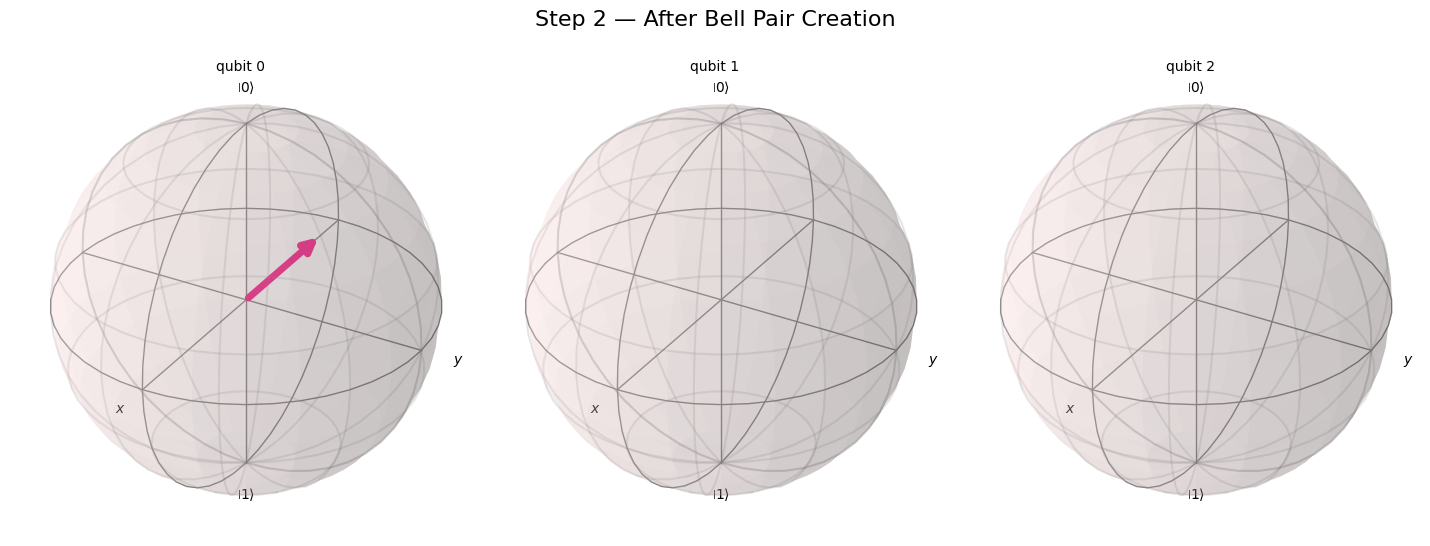

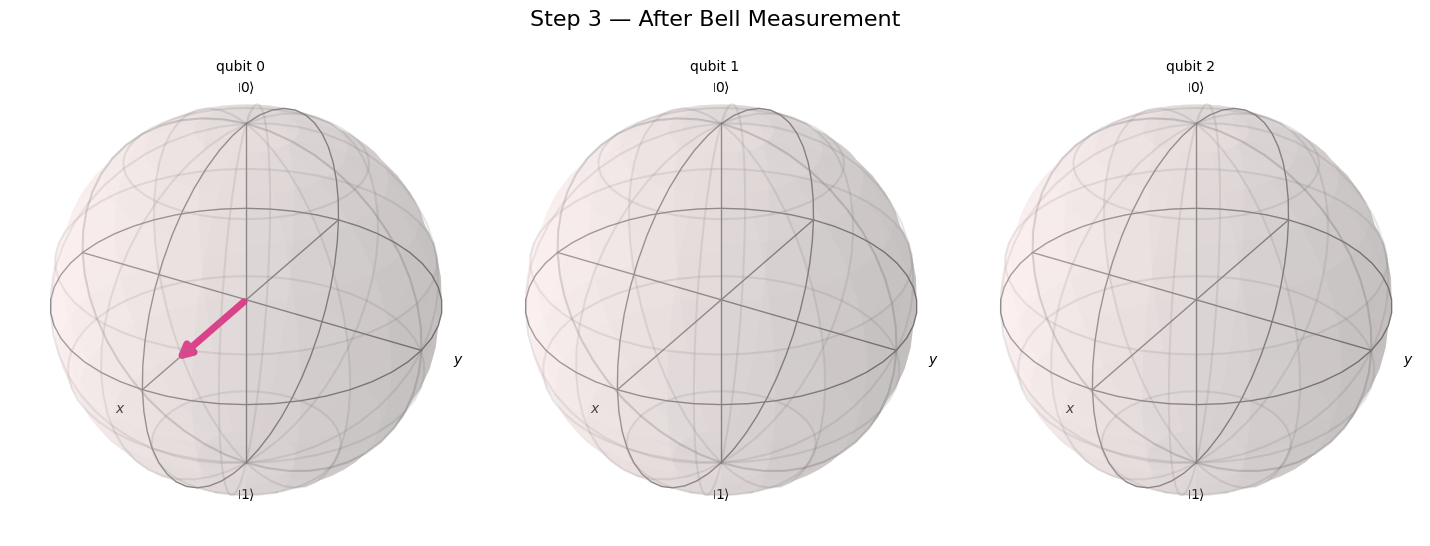

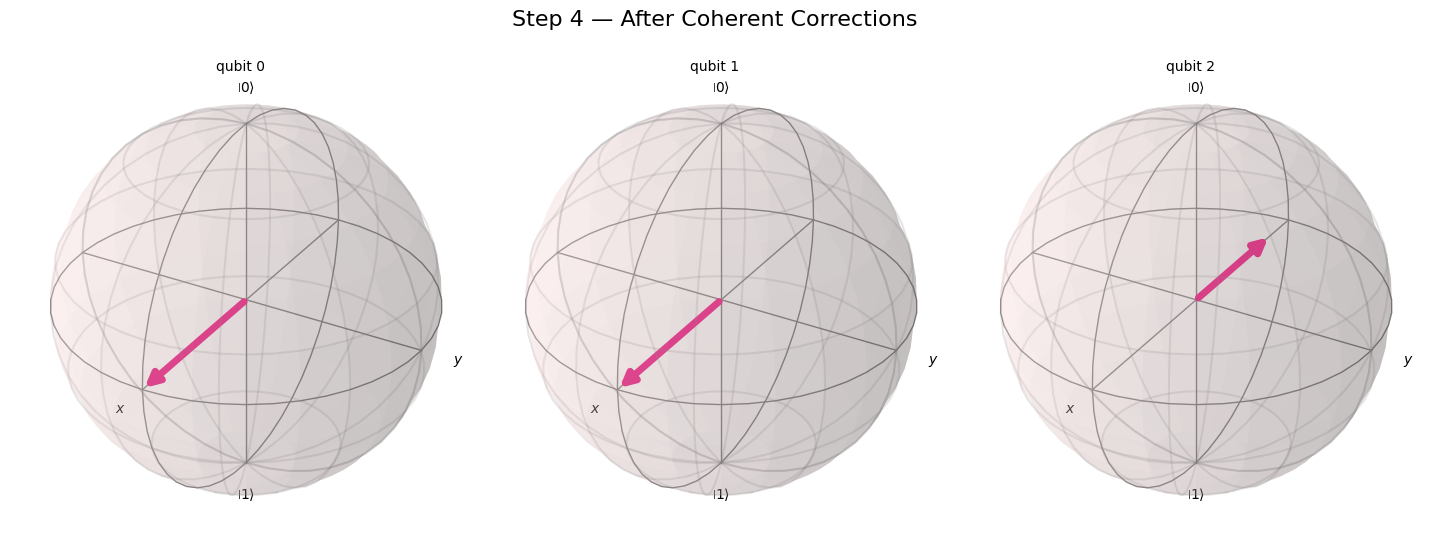


Task 5 — Fidelity under depolarizing noise = 1.000000


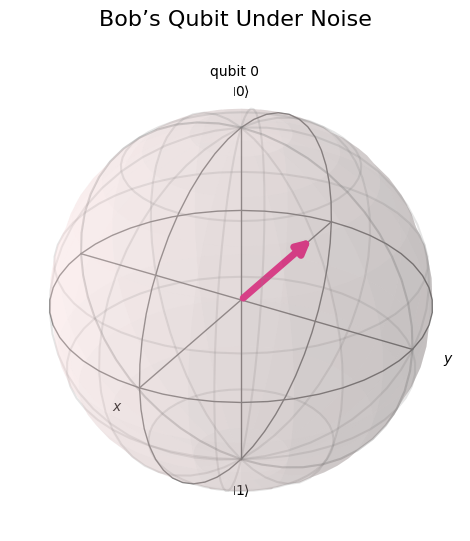

In [15]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc
!pip install qiskit qiskit-aer pylatexenc -q


from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt


# Task 1 — Custom State Teleportation

theta, phi = np.pi / 4, np.pi / 2   # You can change these (π/4, π/2, etc.)
qc = QuantumCircuit(3)

# Prepare custom quantum state |ψ⟩
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv_initial, title="Initial Custom State (Qubit 0)"))

# Create entanglement (Bell pair)
qc.h(1)
qc.cx(1, 2)

# Bell measurement (entangles sender qubits)
qc.cx(0, 1)
qc.h(0)

# Apply corrections (coherent)
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector()

sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = result.get_statevector()

# Extract receiver's (Bob's) qubit
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2

print(f"Task 1 — Fidelity = {fidelity:.6f}")
display(plot_bloch_multivector(Statevector(bob_state), title="Bob’s Qubit After Teleportation"))


# Task 2 — Add Classical Measurement & Conditional Corrections

qc = QuantumCircuit(3, 2)
theta, phi = np.pi/3, np.pi/5
qc.ry(theta, 0)
qc.rz(phi, 0)

qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

# Modern conditional syntax using if_test()
with qc.if_test((0, 1)):
    qc.x(2)
with qc.if_test((0, 2)):
    qc.z(2)
with qc.if_test((0, 3)):
    qc.x(2)
    qc.z(2)

qc.save_statevector()

compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = result.get_statevector()

print("\nTask 2 — Bloch sphere of Bob’s final qubit after classical corrections:")
display(plot_bloch_multivector(sv_final))


# Task 3 — Fidelity Analysis for Multiple Random States

def teleport_fidelity(theta, phi):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_initial = Statevector.from_instruction(qc)

    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)
    qc.save_statevector()

    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    sv_final = result.get_statevector()

    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]
    return np.abs(np.vdot(init_state, bob_state))**2

thetas = np.random.uniform(0, np.pi, 20)
phis = np.random.uniform(0, 2*np.pi, 20)
fidelities = [teleport_fidelity(t, p) for t, p in zip(thetas, phis)]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 21), fidelities, 'o-', label='Fidelity')
plt.axhline(np.mean(fidelities), color='r', linestyle='--', label=f'Avg = {np.mean(fidelities):.4f}')
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Task 3 — Teleportation Fidelity Across Random States")
plt.legend()
plt.grid(True)
plt.show()

# Task 4 — Step-by-Step Visualization

qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/3
qc.ry(theta, 0)
qc.rz(phi, 0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 1 — Initial State (Qubit 0)"))

qc.h(1)
qc.cx(1, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 2 — After Bell Pair Creation"))

qc.cx(0, 1)
qc.h(0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 3 — After Bell Measurement"))

qc.cx(1, 2)
qc.cz(0, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Step 4 — After Coherent Corrections"))


# Task 5 — Introduce Noise (Depolarizing)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['rz', 'ry', 'h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])
sim_noisy = AerSimulator(noise_model=noise_model)

qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/3
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector()

compiled = transpile(qc, sim_noisy)
result = sim_noisy.run(compiled).result()
sv_final = result.get_statevector()

rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2

print(f"\nTask 5 — Fidelity under depolarizing noise = {fidelity:.6f}")
display(plot_bloch_multivector(Statevector(bob_state), title="Bob’s Qubit Under Noise"))
